# Import / Setting

In [14]:
import random, os
import warnings
warnings.filterwarnings('ignore')

from glob import glob
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

from PIL import Image

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

import albumentations as A
from albumentations import Compose, OneOf, Resize, Normalize
from albumentations.pytorch import ToTensor

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device = {DEVICE}')

def seed_everything(seed = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f'Seed set = {seed}')
    
seed_everything()

ModuleNotFoundError: No module named 'qudida'

# Data Preparation

Data는 glob을 통해 path만 받아오고, 학습할 때 불러오면서 전처리하도록 작성했습니다.

In [ ]:
submission = pd.read_csv('sample_submission.csv')
train_imgs = glob('./train/*/*')
train_labels = [path.split('/')[1] for path in train_imgs]
test_imgs = glob('test/*')

In [ ]:
label_map = {
    'airplane' : 0, 
    'automobile': 1, 
    'bird': 2,
    'cat': 3, 
    'deer': 4, 
    'dog': 5, 
    'frog': 6,
    'horse': 7, 
    'ship': 8, 
    'truck': 9,
}

In [ ]:
class train_dataset(Dataset):
    def __init__(self, imgs, labels, transform = None):
        super(train_dataset, self).__init__()
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        X = np.array(Image.open(self.imgs[idx]))
        y = np.eye(10)[label_map[self.labels[idx]]]
        
        if self.transform:
            img = self.transform(image = X)['image']
        else:
            img = X
        y = torch.tensor(y, dtype = torch.float32)
        return img, y
    
class test_dataset(Dataset):
    def __init__(self, imgs, transform = None, n_tta = None):
        super(test_dataset, self).__init__()
        self.imgs = imgs
        self.transform = transform
        self.n_tta = n_tta
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        X = np.array(Image.open(self.imgs[idx]))
        if self.transform:
            if self.n_tta:
                imgs = [self.transform(image = X)['image'] for _ in range(self.n_tta)]
                return imgs
            else:
                img = self.transform(image = X)['image']
                return img
        else:
            return X

# Split Data for Validation

In [ ]:
train_imgs, val_imgs, train_labels, val_labels = train_test_split(train_imgs, train_labels, test_size = 0.2, 
                                                                  stratify = train_labels, random_state = 42)
len(train_imgs), len(val_imgs), len(train_labels), len(val_labels),

(40000, 10000, 40000, 10000)

# Build model

제가 직접 작성한 34-layer ResNet입니다. 틀린 부분이 있을 수 있습니다..

In [ ]:
class Conv_Block_x2(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(Conv_Block_x2, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels, out_channels, (3, 3), stride, padding = (1, 1), bias = False)
        self.bn_1 = nn.BatchNorm2d(out_channels)
        
        self.conv_2 = nn.Conv2d(out_channels, out_channels, (3, 3), 1, padding = (1, 1), bias = False)
        self.bn_2 = nn.BatchNorm2d(out_channels)
        
        self.conv_shortcut = nn.Conv2d(in_channels, out_channels, (1, 1), stride, bias = False)
        self.bn_shortcut = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = self.relu(x)
        
        x = self.conv_2(x)
        x = self.bn_2(x)
        
        shortcut = self.conv_shortcut(inputs)
        shortcut = self.bn_shortcut(shortcut)
        
        x += shortcut
        outputs = self.relu(x)
        return outputs
    
class Identity_Block_x2(nn.Module):
    def __init__(self, channels):
        super(Identity_Block_x2, self).__init__()

        self.conv_1 = nn.Conv2d(channels, channels, (1, 1), bias = False)
        self.bn_1 = nn.BatchNorm2d(channels)
        
        self.conv_2 = nn.Conv2d(channels, channels, (3, 3), 1, padding = (1, 1), bias = False)
        self.bn_2 = nn.BatchNorm2d(channels)
        
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = self.relu(x)
        
        x = self.conv_2(x)
        x = self.bn_2(x)
        
        x += inputs
        outputs = self.relu(x)
        return outputs
    
class ResNet34(nn.Module):
    def __init__(self):
        super(ResNet34, self).__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(3, 64, (7, 7), 2, padding = (3, 3), bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((3, 3), 2, padding = (1, 1)),
        )
        
        self.block_2 = nn.Sequential(
            Identity_Block_x2(64),
            Identity_Block_x2(64),
            Identity_Block_x2(64),
        )
        
        self.block_3 = nn.Sequential(
            Conv_Block_x2(64, 128, 2),
            Identity_Block_x2(128),
            Identity_Block_x2(128),
            Identity_Block_x2(128),
        )
        
        self.block_4 = nn.Sequential(
            Conv_Block_x2(128, 256, 2),
            Identity_Block_x2(256),
            Identity_Block_x2(256),
            Identity_Block_x2(256),
            Identity_Block_x2(256),
            Identity_Block_x2(256),
        )
        
        self.block_5 = nn.Sequential(
            Conv_Block_x2(256, 512, 2),
            Identity_Block_x2(512),
            Identity_Block_x2(512),
        )
        
        self.classifier = nn.Linear(512, 10)
        
    def forward(self, inputs):
        x = self.block_1(inputs)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        x = torch.mean(x, axis = [2, 3])
        outputs = self.classifier(x)
        return outputs

# Hyper Parameter setting

In [ ]:
N_EPOCH = 50
LR = 1e-3
BATCH_SIZE = 100
N_TTA = 5

# Data Augmentation setting

학습 시에는 Augmentation을 포함한 Transformation을 진행했고, validation용으로는 Resize, Normalize만 진행했습니다.

그리고 학습용 Transformation을 TTA에 똑같이 적용했습니다.

In [ ]:
train_transform = Compose([
    Resize(224, 224),
    A.HorizontalFlip(),
    OneOf([
        A.IAAAdditiveGaussianNoise(),
        A.GaussNoise(),
        ], p = 0.2),
    OneOf([
        A.MotionBlur(blur_limit = 3, p = 0.2),
        A.MedianBlur(blur_limit = 3, p = 0.1),
        A.Blur(blur_limit = 3, p = 0.1),
        ], p = 0.2),
    A.ShiftScaleRotate(rotate_limit = 15),
    OneOf([
        A.OpticalDistortion(p = 0.3),
        A.GridDistortion(p = 0.1),
        A.IAAPiecewiseAffine(p = 0.3),
        ], p = 0.2),
    OneOf([
        A.CLAHE(clip_limit = 2),
        A.IAASharpen(),
        A.IAAEmboss(),
        A.RandomBrightnessContrast(),
        ], p = 0.3),
    A.HueSaturationValue(p = 0.3),
    Normalize(),
    ToTensor(),
])

val_transform = Compose([
    Resize(224, 224),
    Normalize(),
    ToTensor(),
])

NameError: name 'Compose' is not defined

In [ ]:
def display_aug(imgs, transform, labels = None, n_aug = 5, cols = 5):
    idx = random.randint(0, len(imgs) - 1)
    
    plt.imshow(np.array(Image.open(imgs[idx])))
    
    if labels:
        label = labels[idx]
        plt.title(label)
    plt.show()
    
    rows = int(np.ceil(n_aug / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize = (cols * 5, rows * 5))

    for i in range(n_aug):
        img = np.array(Image.open(imgs[idx]))
        img = transform(image = img)['image']
        img = np.clip(img.numpy().transpose(1, 2, 0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        axes.flat[i].imshow(img)
    plt.show()

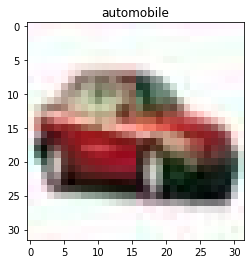

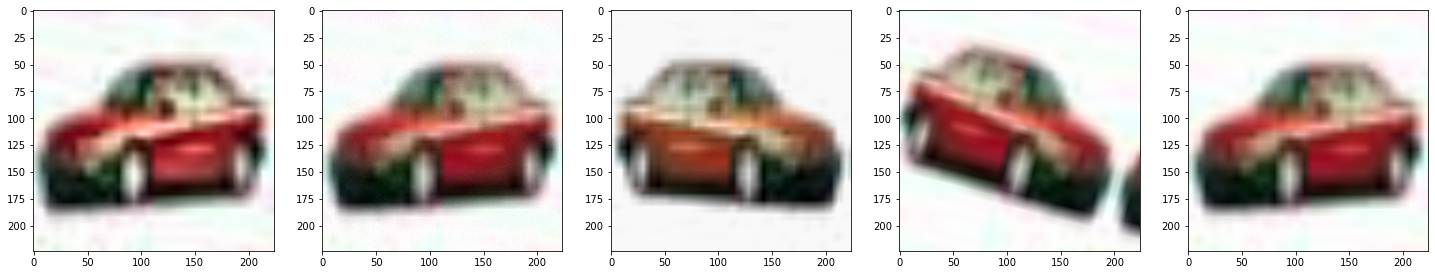

In [ ]:
display_aug(train_imgs, train_transform, labels = train_labels)

# Train Model

* Loss = BinaryCrossEntropy
* Optimizer = AdamW
* LR Scheduler = ReduceLROnPlateau(min_lr = 0.00005)

학습을 진행하며 Validation accuracy 최대치가 갱신될 때마다 weight를 저장했습니다.

학습은 약 50 epoch 진행했을 때 Validation accuracy가 0.89 근처에서 saturation 되었습니다.

그 후 가장 Validation accuracy가 높게 나왔던 weight를 다시 load 해주었습니다.

In [ ]:
train_loader = DataLoader(train_dataset(train_imgs, train_labels, transform = train_transform),
                          shuffle = True, batch_size = BATCH_SIZE)
val_loader = DataLoader(train_dataset(val_imgs, val_labels, transform = val_transform),
                        shuffle = False, batch_size = BATCH_SIZE)

In [ ]:
model = ResNet34().to(DEVICE)

criterion = nn.BCEWithLogitsLoss().to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr = LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', patience = 2, factor = 0.5, min_lr = 5e-5)

total_batch = len(train_loader)

In [ ]:
val_acc = -1

In [ ]:
for epoch in range(N_EPOCH):
    avg_cost = 0
    pbar = tqdm(train_loader)

    model.train()
    for X, y in pbar:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, y)
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_batch
        
    model.eval()
    with torch.no_grad():
        mean_acc = 0
        for X, y in val_loader:
            X = X.to(DEVICE)
            pred = np.argmax(model(X).cpu().numpy(), axis = 1)
            y = np.argmax(y.numpy(), axis = 1)
            acc = accuracy_score(y, pred)
            mean_acc += acc / len(val_loader)
    
    scheduler.step(mean_acc)
    
    if val_acc < mean_acc:
        print(f'val_acc improved {val_acc:.4f} to {mean_acc:.4f}')
        val_acc = mean_acc
        torch.save(model.state_dict(), 'ResNet34_best_val_acc.pt')
    
    print(f'[Epoch {epoch + 1} / {N_EPOCH}] cost = {avg_cost:.4f}, val_acc = {mean_acc:.4f}')

  0%|          | 0/400 [00:00<?, ?it/s]

val_acc improved -1.0000 to 0.3504
[Epoch 1 / 50] cost = 0.2564, val_acc = 0.3504


  0%|          | 0/400 [00:00<?, ?it/s]

val_acc improved 0.3504 to 0.5956
[Epoch 2 / 50] cost = 0.1934, val_acc = 0.5956


  0%|          | 0/400 [00:00<?, ?it/s]

val_acc improved 0.5956 to 0.6246
[Epoch 3 / 50] cost = 0.1634, val_acc = 0.6246


  0%|          | 0/400 [00:00<?, ?it/s]

val_acc improved 0.6246 to 0.6454
[Epoch 4 / 50] cost = 0.1433, val_acc = 0.6454


  0%|          | 0/400 [00:00<?, ?it/s]

val_acc improved 0.6454 to 0.7194
[Epoch 5 / 50] cost = 0.1298, val_acc = 0.7194


  0%|          | 0/400 [00:00<?, ?it/s]

val_acc improved 0.7194 to 0.7598
[Epoch 6 / 50] cost = 0.1180, val_acc = 0.7598


  0%|          | 0/400 [00:00<?, ?it/s]

val_acc improved 0.7598 to 0.7915
[Epoch 7 / 50] cost = 0.1096, val_acc = 0.7915


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 8 / 50] cost = 0.1012, val_acc = 0.7853


  0%|          | 0/400 [00:00<?, ?it/s]

val_acc improved 0.7915 to 0.8197
[Epoch 9 / 50] cost = 0.0961, val_acc = 0.8197


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 10 / 50] cost = 0.0903, val_acc = 0.8089


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 11 / 50] cost = 0.0853, val_acc = 0.8051


  0%|          | 0/400 [00:00<?, ?it/s]

val_acc improved 0.8197 to 0.8282
[Epoch 12 / 50] cost = 0.0806, val_acc = 0.8282


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 13 / 50] cost = 0.0774, val_acc = 0.8224


  0%|          | 0/400 [00:00<?, ?it/s]

val_acc improved 0.8282 to 0.8356
[Epoch 14 / 50] cost = 0.0729, val_acc = 0.8356


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 15 / 50] cost = 0.0696, val_acc = 0.8279


  0%|          | 0/400 [00:00<?, ?it/s]

val_acc improved 0.8356 to 0.8362
[Epoch 16 / 50] cost = 0.0657, val_acc = 0.8362


  0%|          | 0/400 [00:00<?, ?it/s]

val_acc improved 0.8362 to 0.8616
[Epoch 17 / 50] cost = 0.0620, val_acc = 0.8616


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 18 / 50] cost = 0.0592, val_acc = 0.8401


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 19 / 50] cost = 0.0564, val_acc = 0.8595


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 20 / 50] cost = 0.0542, val_acc = 0.8473


  0%|          | 0/400 [00:00<?, ?it/s]

val_acc improved 0.8616 to 0.8749
[Epoch 21 / 50] cost = 0.0405, val_acc = 0.8749


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 22 / 50] cost = 0.0380, val_acc = 0.8738


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 23 / 50] cost = 0.0352, val_acc = 0.8734


  0%|          | 0/400 [00:00<?, ?it/s]

val_acc improved 0.8749 to 0.8759
[Epoch 24 / 50] cost = 0.0338, val_acc = 0.8759


  0%|          | 0/400 [00:00<?, ?it/s]

val_acc improved 0.8759 to 0.8778
[Epoch 25 / 50] cost = 0.0331, val_acc = 0.8778


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 26 / 50] cost = 0.0314, val_acc = 0.8740


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 27 / 50] cost = 0.0294, val_acc = 0.8766


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 28 / 50] cost = 0.0284, val_acc = 0.8768


  0%|          | 0/400 [00:00<?, ?it/s]

val_acc improved 0.8778 to 0.8859
[Epoch 29 / 50] cost = 0.0232, val_acc = 0.8859


  0%|          | 0/400 [00:00<?, ?it/s]

val_acc improved 0.8859 to 0.8861
[Epoch 30 / 50] cost = 0.0214, val_acc = 0.8861


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 31 / 50] cost = 0.0203, val_acc = 0.8857


  0%|          | 0/400 [00:00<?, ?it/s]

val_acc improved 0.8861 to 0.8877
[Epoch 32 / 50] cost = 0.0196, val_acc = 0.8877


  0%|          | 0/400 [00:00<?, ?it/s]

val_acc improved 0.8877 to 0.8912
[Epoch 33 / 50] cost = 0.0192, val_acc = 0.8912


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 34 / 50] cost = 0.0182, val_acc = 0.8883


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 35 / 50] cost = 0.0177, val_acc = 0.8890


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 36 / 50] cost = 0.0175, val_acc = 0.8885


  0%|          | 0/400 [00:00<?, ?it/s]

val_acc improved 0.8912 to 0.8945
[Epoch 37 / 50] cost = 0.0150, val_acc = 0.8945


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 38 / 50] cost = 0.0142, val_acc = 0.8932


  0%|          | 0/400 [00:00<?, ?it/s]

val_acc improved 0.8945 to 0.8951
[Epoch 39 / 50] cost = 0.0144, val_acc = 0.8951


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 40 / 50] cost = 0.0136, val_acc = 0.8933


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 41 / 50] cost = 0.0133, val_acc = 0.8913


  0%|          | 0/400 [00:00<?, ?it/s]

val_acc improved 0.8951 to 0.8955
[Epoch 42 / 50] cost = 0.0131, val_acc = 0.8955


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 43 / 50] cost = 0.0124, val_acc = 0.8925


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 44 / 50] cost = 0.0126, val_acc = 0.8949


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 45 / 50] cost = 0.0122, val_acc = 0.8924


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 46 / 50] cost = 0.0111, val_acc = 0.8938


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 47 / 50] cost = 0.0110, val_acc = 0.8950


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 48 / 50] cost = 0.0102, val_acc = 0.8948


  0%|          | 0/400 [00:00<?, ?it/s]

val_acc improved 0.8955 to 0.8971
[Epoch 49 / 50] cost = 0.0097, val_acc = 0.8971


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 50 / 50] cost = 0.0099, val_acc = 0.8940


# Load Best Weights

In [ ]:
model.load_state_dict(torch.load('ResNet34_best_val_acc.pt'))

<All keys matched successfully>

# Prediction using TTA

N_TTA = 5로 주어 5번의 Test time augmentation을 진행하고 각 class의 sigmoid 평균값이 가장 높은 class로 예측했습니다.

TTA에 대한 개념만 줏어듣고 제 마음대로 코드를 작성해서 많이 미흡할 수 있습니다..

In [ ]:
test_loader = DataLoader(test_dataset(test_imgs, transform = train_transform, n_tta = N_TTA),
                         shuffle=False, batch_size = BATCH_SIZE)

model.eval()
preds = []
with torch.no_grad():
    for imgs in tqdm(test_loader):
        pred = [torch.sigmoid(model(X.to(DEVICE))).cpu().numpy() for X in imgs]
        pred = np.mean(np.array(pred), axis = 0)
        preds.append(pred)

pred = np.argmax(np.concatenate(np.array(preds)), axis = 1)
pred.shape

  0%|          | 0/100 [00:00<?, ?it/s]

(10000,)

# Submission

In [ ]:
submission['target'] = [list(label_map.keys())[i] for i in pred]
save_path = 'resnet34_50epoch_aug_tta5.csv'
submission.to_csv(save_path, index = False)
pd.read_csv(save_path)

,id,target
0,0000.jpg,horse
1,0001.jpg,bird
2,0002.jpg,airplane
3,0003.jpg,cat
4,0004.jpg,airplane
...,...,...
9995,9995.jpg,dog
9996,9996.jpg,dog
9997,9997.jpg,deer
9998,9998.jpg,automobile


# Check Prediction

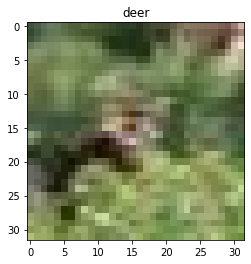

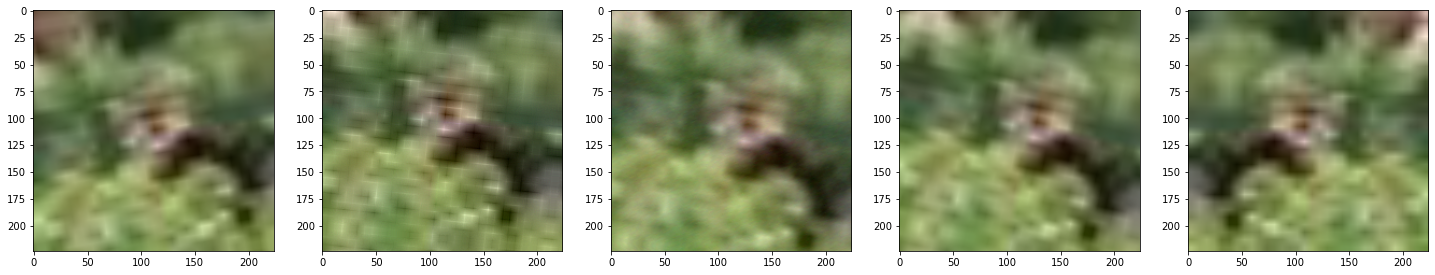

In [ ]:
display_aug(test_imgs, train_transform, list(submission['target']))